In [1]:
import pandas as pd
import sqlite3

In [2]:
DATA_FOLDER = "../sources/data/"
db_path = DATA_FOLDER + "challenge.db"
sql_file_path = DATA_FOLDER + "challenge_db_create.sql" 
conn = sqlite3.connect(db_path)

In [3]:
# Loading the data from db for indepth analysis of the dataset

df_session_sources = pd.read_sql_query("""SELECT * FROM session_sources""", conn)
df_conversions = pd.read_sql_query("""SELECT * FROM conversions""", conn)

In [11]:
# info on the dataframe and datatype of the fields
print(f"No. of records in df_session_sources: {df_session_sources.shape[0]}")
print(f"No. of records in df_conversions: {df_conversions.shape[0]}")
print(df_session_sources.info())
print(df_conversions.info())

No. of records in df_session_sources: 450616
No. of records in df_conversions: 2000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450616 entries, 0 to 450615
Data columns (total 8 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   session_id              450616 non-null  object
 1   user_id                 450616 non-null  object
 2   event_date              450616 non-null  object
 3   event_time              450616 non-null  object
 4   channel_name            450616 non-null  object
 5   holder_engagement       450616 non-null  int64 
 6   closer_engagement       450616 non-null  int64 
 7   impression_interaction  450616 non-null  int64 
dtypes: int64(3), object(5)
memory usage: 27.5+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   conv_id    2000 non-null   ob

### Observations
- From the results we observe that the we have 2000 customer journeys (The documentation states that we need from 10-100K unique customer journeys). This might not be sufficient to train the parameters well also depends on how the model is trained. (Should also check for the number of sessions in each customer journey)
- Date and time are stored separately and should be parsed to datetime

In [12]:
# 1. Merge the DataFrames
merged_df = pd.merge(df_session_sources, df_conversions, on='user_id', how='inner')
print(f"No. of sessions that are part of a customer journey: {merged_df.shape[0]}")
# 2. Filter based on date and time
merged_df['event_datetime'] = pd.to_datetime(merged_df['event_date'] + ' ' + merged_df['event_time'])
merged_df['conv_datetime'] = pd.to_datetime(merged_df['conv_date'] + ' ' + merged_df['conv_time'])
# Eliminating session that happened after the conversion has taken place
merged_df = merged_df[
    (merged_df['event_datetime'] <= merged_df['conv_datetime'])]
print(f"No. of sessions that took place before a conversion in a customer journey: {merged_df.shape[0]}")
merged_df["conversion"] = (
            (merged_df["conv_datetime"] == merged_df["event_datetime"]) 
        ).astype(int)

merged_df["timestamp"] = pd.to_datetime(merged_df["event_datetime"], format="%Y-%m-%d %H:%M:%S").astype(str)

# Modifying the columns to match the training dataset
merged_df = merged_df.drop(["user_id", "conv_date", "event_date", "conv_time", "event_time", "revenue", "event_datetime", "conv_datetime"], axis=1)
merged_df = merged_df.rename(columns={"conv_id": "conversion_id", "channel_name": "channel_label"})


No. of sessions that are part of a customer journey: 4462
No. of sessions that took place before a conversion in a customer journey: 3709


## Observation
- out of 450616 sessions only 4462 sessions are included in a customer journey, of which 3709 Customer Journeys had a conversion other sessions took place after the conversion. 

In [14]:
training_set_file_path = DATA_FOLDER+'training_set.json'
merged_df.to_json(training_set_file_path, orient="records")

Text(0, 0.5, 'Frequency')

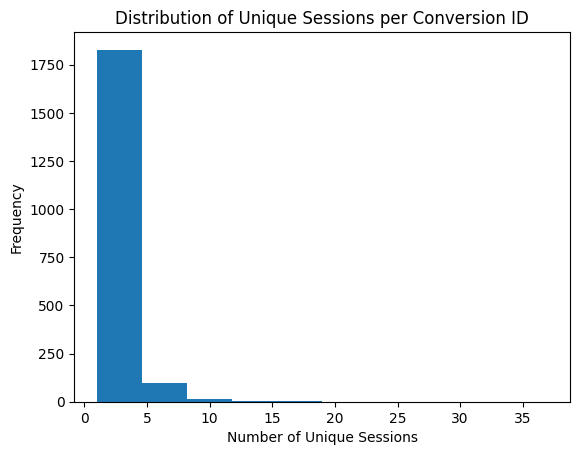

In [26]:
import matplotlib.pyplot as plt
# Group the data by `conversion_id`
grouped_data = merged_df.groupby('conversion_id').agg(
    # Aggregate all unique `session_id` values for each `conversion_id`
    session_ids=('session_id', lambda x: list(x.unique())),
    # Count the number of unique `session_id` values for each `conversion_id`
    num_unique_sessions=('session_id', 'nunique')
).reset_index()
grouped_data

# Plot the histogram
plt.hist(grouped_data['num_unique_sessions'])

# Set the title
plt.title('Distribution of Unique Sessions per Conversion ID')

# Set the x and y labels
plt.xlabel('Number of Unique Sessions')
plt.ylabel('Frequency')

# Show the

In [11]:
conn = sqlite3.connect(db_path)
df = pd.read_sql_query("""
                          SELECT 
                              c.conv_id as conversion_id, s.session_id, s.channel_name channel_label, s.holder_engagement, s.closer_engagement,
                               c.conv_date, c.conv_time, s.event_date, s.event_time
                               
                          FROM 
                               session_sources s 
                          JOIN 
                              conversions c ON s.user_id = c.user_id  -- Add the missing JOIN condition
                          WHERE
                              s.event_date <= c.conv_date 
                          AND
                              s.event_time <= c.conv_time
                            """, conn) 

In [67]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3709 entries, 0 to 4461
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   session_id              3709 non-null   object
 1   channel_label           3709 non-null   object
 2   holder_engagement       3709 non-null   int64 
 3   closer_engagement       3709 non-null   int64 
 4   impression_interaction  3709 non-null   int64 
 5   conversion_id           3709 non-null   object
 6   conversion              3709 non-null   int64 
 7   timestamp               3709 non-null   object
dtypes: int64(4), object(4)
memory usage: 389.8+ KB
